# HWB - task 5 (masking)
> Discover the secret key using second-order DPA.
You will need trace compression to reduce the amount of measured data
Use a suitable preprocessing function to combine trace samples, limit the distance to a few cycles

In [1]:
import numpy as np
import binascii
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

In [2]:
TRACES_CNT = 2000
TRACE_LENGTH = int(open("traceLength.txt").read().split()[0])

In [3]:
sbox = (
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
    0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
    0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
    0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
    0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
    0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
    0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
    0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
    0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
    0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
    0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
    0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
    0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
    0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
    0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
    0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
    0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
    0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
    0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
    0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
    0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
    0x54, 0xbb, 0x16
)

Oproti předchozím úkolům bylo změneno vytváření matice hypotetických hodnot. Těsně před výpočtem hammingovy váhy zXORujeme matici před SBOXem s maticí po SBOXu.

`sbox[dmat[row][col]] ^ dmat[row][col]`

In [4]:
def create_hypotheses_matrix(plaintext, l):
    # generate key hypotheses
    dmat = np.array([[x for x in range(256)] for y in range(TRACES_CNT)], dtype=np.uint32)
    for i in range(TRACES_CNT):
        # xor row with first byte of plaintext
        dmat[i, :] = dmat[i, :] ^ plaintext[i, l]
    
    for row in range(TRACES_CNT):   
        for col in range(256): 
            # compute hamming weights
            dmat[row][col] = hamming_weight(sbox[dmat[row][col]] ^ dmat[row][col])
    return dmat

Následující kód se ničím neliší oproti útoku na normální kartičku s triggerem.

In [5]:
def load_traces():
    # load and slice traces    
    traces = np.zeros((TRACES_CNT, TRACE_LENGTH), dtype=np.uint32)
    with open("traces.bin", "rb") as file:
        for i in range(0, TRACES_CNT):
            traces[i] = np.fromfile(file, np.uint8, TRACE_LENGTH)
    return traces[:, 10255:572755]


def load_plaintext():
    plaintxt = np.zeros((TRACES_CNT, 16), dtype=np.uint32)
    with open("plaintext.txt", "r") as f:
        for i, line in enumerate(f):
            line = list(binascii.unhexlify(line.strip().replace(" ", "")))
            plaintxt[i, :] = np.array(line, dtype=np.uint32)
    return plaintxt


def hamming_weight(x):
    c = 0
    while x:
        x &= x - 1
        c += 1
    return c


def corr2_coeff(A,B):
    # source: https://stackoverflow.com/a/30143754
    # pearson correlation coeficient
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]
    
    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))


def create_correlation_matrix(x, y):
    # computes correlations between two matrices    
    corr = corr2_coeff(x, y)  # correlation matrix
    corr = np.nan_to_num(corr)
    acorr = np.absolute(corr)  # absolute value
    maxcorr = np.max(acorr)
    print(f"Max correlation: {maxcorr}")
    index = np.where(acorr == maxcorr)
    return int(index[0])

## Maskování



### Trigger

Nejdříve manuálně najdeme začátek šifrování. Kde je zhruba začátek lze vidět na následujícím grafu, po bližším prozkoumání jsme začátek určili - 10255.

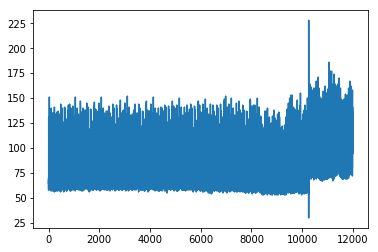

In [6]:
tr = np.zeros((TRACES_CNT, TRACE_LENGTH), dtype=np.uint32)
with open("traces.bin", "rb") as file:
    for i in range(0, TRACES_CNT):
        tr[i] = np.fromfile(file, np.uint8, TRACE_LENGTH)

plt.plot(tr[0][0:12000])
plt.show()

### Komprese

Zkomprimujeme každých 5 bodů do jednoho sečtením.

In [7]:
def compress(trace, n):
    n = 5
    dmat = np.zeros(len(trace) // n, dtype=np.uint32)
    for i in range(len(dmat)):
        dmat[i] = trace[n * i] + trace[n * i + 1] + trace[n * i + 2] + trace[n * i + 3] + trace[n * i + 4]
    return dmat

### Kombinace

Funkce `combine()` nakombinuje každý bod s 50 dalšími, tzn. s 10 dalšími cykly. Z toho jsme vzali pouze cykly 21720 až 21980 a to korelovali s hypotetickou maticí spotřeby, což byla Hammingova váha xoru hodnot před sboxem a po sboxu.

In [8]:
def combine(trace, start, stop, cnt):
    dmat = np.zeros((stop - start + 1) * cnt)
    for i in range(stop - start):
        for j in range(1, cnt + 1):
            dmat[i * cnt + j - 1] = int(abs(hamming_weight(trace[start + i]) - hamming_weight(trace[start + i + j])))
    return dmat

## MAIN

In [9]:
# nacteni plaintextu a trace
plaintext = load_plaintext()
traces = load_traces()

i = 0

combined = []
print("Progress...", end="", flush=True)
for trace in traces:
    i += 1
    if i % 100 == 0:
        print(f"{i}", end="", flush=True)
    elif i % 10 == 0:
        print(".", end="", flush=True)
    trace = compress(trace, 5)
    trace = combine(trace, 21720 * 5, 21980 * 5, 50)
    combined.append(trace)
    
combined = np.transpose(np.array(combined))
combined = combined.astype('int32') 

Progress............100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000

In [10]:
np.seterr(divide='ignore', invalid='ignore')

key = []
for i in range(16):
    print(f"Byte: {i}, ", end="")
    hypot_matrix = create_hypotheses_matrix(plaintext, i)
    hypot_matrix = np.transpose(np.array(hypot_matrix))
    index = create_correlation_matrix(hypot_matrix, combined)
    key.append(index)

print("KEY: ", end="")
for k in key:
    print(f"{k:02x} ", end="")

print()

Byte: 0, Max correlation: 0.12495332176801305
Byte: 1, Max correlation: 0.11866470639242616
Byte: 2, Max correlation: 0.12215801516189119
Byte: 3, Max correlation: 0.11652930573306193
Byte: 4, Max correlation: 0.12619491442206995
Byte: 5, Max correlation: 0.11934222850676973
Byte: 6, Max correlation: 0.12139203898858536
Byte: 7, Max correlation: 0.12146733171838875
Byte: 8, Max correlation: 0.12261291348136291
Byte: 9, Max correlation: 0.12455204747720482
Byte: 10, Max correlation: 0.1138277596983755
Byte: 11, Max correlation: 0.11738280428301766
Byte: 12, Max correlation: 0.1190708279389365
Byte: 13, Max correlation: 0.12156188931450584
Byte: 14, Max correlation: 0.11872986088246101
Byte: 15, Max correlation: 0.12239483611613536
KEY: 0b 7d dd 55 b5 d2 5a cf 2e 4a cc c0 6a fd fe bb 
